# Fiscal policy in HANK

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Q1 - Household Jacobians](#toc2_)    
- 3. [Q2 - Government spending shocks](#toc3_)    
- 4. [Q3](#toc4_)    
- 5. [Q4: Active monetary policy](#toc5_)    
- 6. [Q5: The Philips Curve](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKModel import HANKModelClass
from steady_state import obj_ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANKModelClass(name='baseline')

In [3]:
model.find_ss(do_print=True)

steady state found in 9.7 secs
 beta =   0.9767
 r    =   0.0050
 B   =   1.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


In [4]:
ss = model.ss 
par = model.par
MPC = np.sum(ss.D[:,:,:-1]*(ss.c[:,:,1:]-ss.c[:,:,:-1])/((1+ss.r)*(par.a_grid[1:]-par.a_grid[:-1])))
print(f'{MPC:.2f}')

0.29


## 2. <a id='toc2_'></a>[Q1 - Household Jacobians](#toc0_)

Compute and plot selected columns of the household Jacobians for Z,chi and r. 

Are the MPCs out of Z and chi different? why?

In [5]:
model._compute_jac_hh()

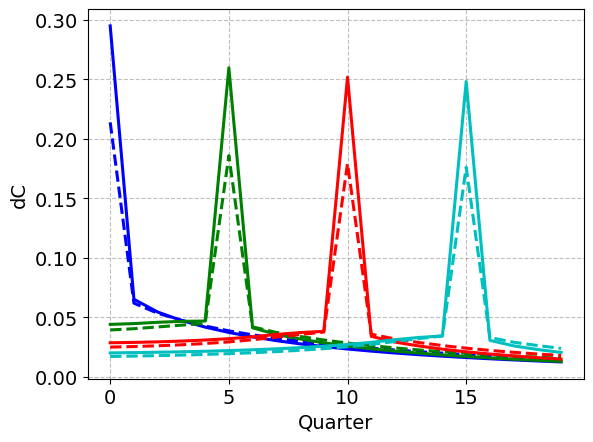

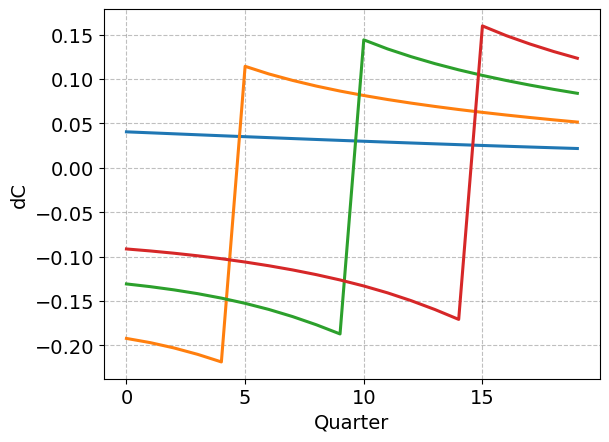

In [6]:
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i,j in enumerate([0,5,10,15]):
    plt.plot(model.jac_hh[('C_hh', 'chi')][:20,j], linewidth=2.2,color=color_list[i])
    plt.plot(model.jac_hh[('C_hh', 'Z')][:20,j], linewidth=2.2,color=color_list[i],linestyle='--')

plt.ylabel('dC')
plt.xlabel('Quarter')
plt.show()

for j in [0,5,10,15]:
    plt.plot(model.jac_hh[('C_hh', 'r')][:20,j], linewidth=2.2)
plt.ylabel('dC')
plt.xlabel('Quarter')
plt.show()

## 3. <a id='toc3_'></a>[Q2 - Government spending shocks](#toc0_)

In [7]:
model.test_path()

shocks: G 
unknowns: pi_w L 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  w                0.0e+00
  pi               0.0e+00
  Y                0.0e+00
 blocks.central_bank
  r                0.0e+00
 blocks.government
  chi              0.0e+00
  B                0.0e+00
  tau              0.0e+00
  taxes            0.0e+00
  Z                0.0e+00
 hh
  A_hh             2.7e-10
  C_hh             1.5e-11
 blocks.NKWC
  NKWC_res         4.7e-12 [target]
 blocks.market_clearing
  A                0.0e+00
  clearing_A       2.5e-10 [target]
  clearing_Y       1.5e-11


In [8]:
# deficit financed 
model.compute_jacs(skip_shocks=False)
model.find_IRFs(shocks=['G'])

# tax financed 
model_tax = model.copy() 
model_tax.par.omega = 50.   

model_tax.compute_jacs(skip_shocks=False)
model_tax.find_IRFs(shocks=['G'])

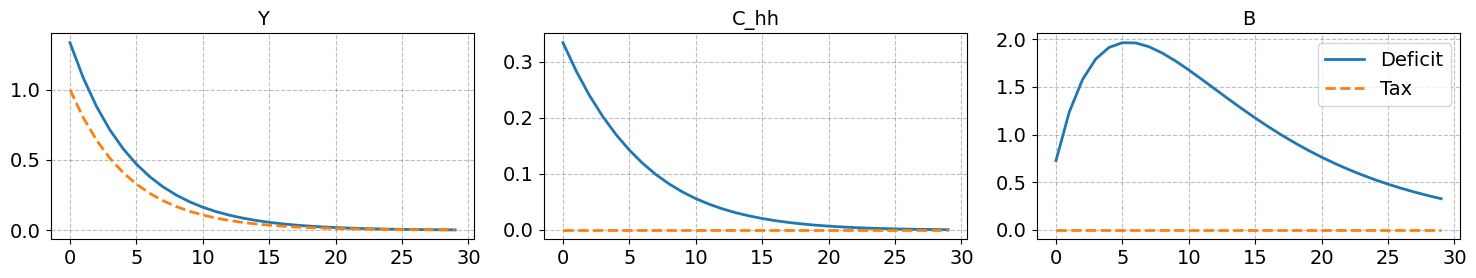

In [9]:
plist = ['Y', 'C_hh', 'B']
fig, axs = plt.subplots(1, len(plist), figsize=(15, 3)) # 1 row, 3 columnsze
for j,var in enumerate(plist):
    axs[j].set_title(var, fontsize=14)
    axs[j].plot(model.IRF[var][:30]*100, linewidth=2, label='Deficit')
    axs[j].plot(model_tax.IRF[var][:30]*100, linewidth=2, linestyle='--', label='Tax')

plt.tight_layout()
plt.legend()
plt.show()


## 4. <a id='toc4_'></a>[Q3 - Analytical solution in sequence-space](#toc0_)

Show that you get the same IRF for output $Y$ as in the automated numerical solution, if you use the analytical sequence space formula to compute $d\boldsymbol{Y}$:

\begin{gather*}
d\boldsymbol{Y}=d\boldsymbol{G}+\mathcal{M}\boldsymbol{M}\left[d\boldsymbol{G}-d\boldsymbol{T}\right]
\end{gather*}
where:
\begin{gather*}
\mathcal{M}=\left(\boldsymbol{I}-\boldsymbol{M}\right)^{-1}
\end{gather*}
where $\boldsymbol{I}$ is a $T \times T$ identity matrix.

Hints: You can find $\boldsymbol{M}$ in *model.jac_hh[('C_hh', 'Z')]*. You can create an identity matrix using *np.eye()*. You can invert a matrix using np.linalg.inv(). Remeber to use *@* when doing matrix multiplication. 

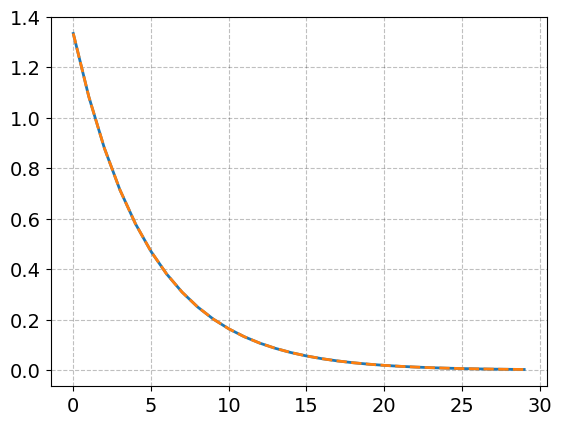

In [10]:
M = model.jac_hh[('C_hh', 'Z')] 
dG = model.IRF['G']
dT = model.IRF['taxes'] 

mathcal_M = np.linalg.inv(np.eye(model.par.T) - M)

dY_analytical = dG + mathcal_M @ M @ (dG-dT)

plt.plot(dY_analytical[:30]*100, linewidth=2, label='Analytical')
plt.plot(model.IRF['Y'][:30]*100, '--', linewidth=2, label='Numerical')
plt.show()

## 5. <a id='toc5_'></a>[Q4: Active monetary policy](#toc0_)

Assume now that $\phi_\pi = 1.5$. Recompute the IRFs to a fiscal policy spending shock with deficit financed, and under the balanced budget policy. How does the multipliers change? 

Note: You do not need to recompute the steady state.

In [15]:
# deficit financed 
model_r = model.copy()
model_r.par.phi_pi = 1.5 
model_r.compute_jacs(skip_shocks=False)
model_r.find_IRFs(shocks=['G'])

# tax financed 
model_r_tax = model_r.copy() 
model_r_tax.par.phi_pi = 1.5 
model_r_tax.par.omega = 50.   

model_r_tax.compute_jacs(skip_shocks=False)
model_r_tax.find_IRFs(shocks=['G'])

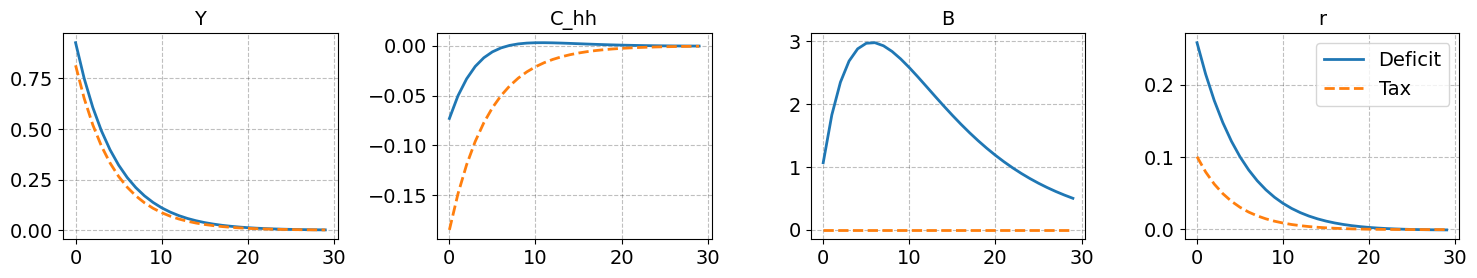

In [16]:
plist = ['Y', 'C_hh', 'B', 'r']
fig, axs = plt.subplots(1, len(plist), figsize=(15, 3)) # 1 row, 3 columnsze
for j,var in enumerate(plist):
    axs[j].set_title(var, fontsize=14)
    axs[j].plot(model_r.IRF[var][:30]*100, linewidth=2, label='Deficit')
    axs[j].plot(model_r_tax.IRF[var][:30]*100, linewidth=2, linestyle='--', label='Tax')

plt.tight_layout()
plt.legend()
plt.show()


## 6. <a id='toc6_'></a>[Q5: The Philips Curve](#toc0_)

Redo the exercise from Q4 with a lower slope of the Phillips Curve, $\kappa=0.01$. How does your results change compared to Q4?

Note: You do not need to recompute the steady state.

In [17]:
# deficit financed 
model_r = model.copy()
model_r.par.phi_pi = 1.5 
model_r.par.kappa = 0.01 
model_r.compute_jacs(skip_shocks=False)
model_r.find_IRFs(shocks=['G'])

# tax financed 
model_r_tax = model_r.copy() 
model_r_tax.par.phi_pi = 1.5 
model_r_tax.par.kappa = 0.01 
model_r_tax.par.omega = 50.   

model_r_tax.compute_jacs(skip_shocks=False)
model_r_tax.find_IRFs(shocks=['G']) 

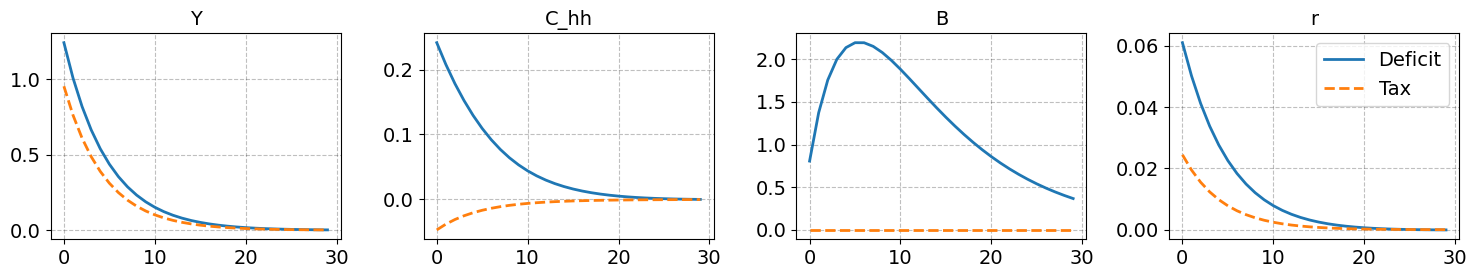

In [18]:
plist = ['Y', 'C_hh', 'B', 'r']
fig, axs = plt.subplots(1, len(plist), figsize=(15, 3)) # 1 row, 3 columnsze
for j,var in enumerate(plist):
    axs[j].set_title(var, fontsize=14)
    axs[j].plot(model_r.IRF[var][:30]*100, linewidth=2, label='Deficit')
    axs[j].plot(model_r_tax.IRF[var][:30]*100, linewidth=2, linestyle='--', label='Tax')

plt.tight_layout()
plt.legend()
plt.show()
